<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Scaling Data Exploration

Once we have things working with a sample, it's time to scale up. In the previous notebook, we looked at precipitation during the first hour of the day and made a histogram. This time, we'll look at the daily precipitation sums.

## Objectives

* Learn how to quickly read thousands of .csv files
* Learn how to plot data on a global scale (literally)

<a href="https://dask.org/">Dask</a> is a library to parallelize Python libraries. Even better? It's device-agnostic, meaning that it scales on GPUs just as easily as it does with CPU computing. 

Dask has a replacement library for <a href="https://docs.rapids.ai/api/cudf/stable/">cuDF</a> with much of the same functions. It even uses the same <a href="https://docs.rapids.ai/api/cudf/stable/api.html?highlight=read_csv#cudf.io.csv.read_csv">read_csv</a> function. Let's give it a try reading in all 1993 of our .csvs

Some interesting problems can start to arise when we start working with large datasets. First, let's specify which columns we want to use with the `usecols` parameter. The earlier we can filter our data, the less wasted computation we'll have. Another parameter we might consider is `dtype`. If we don't specify this, cuDF will sample a number of rows and infer the data type. This can cause issues with rare values. For instance, if we have a float while most of the values in a column are integers, cuDF will throw an error about a type mismatch when it finally finds and reads in the float.

cuDF supports most <a href="https://numpy.org/doc/stable/user/basics.types.html">NumPy Data Types</a> along with a few others. Check out the NumPy documentation and pick types for `LATITUDE`, `LONGITUDE`, and `DlySum`. There are multiple correct answers. Types with fewer bits take less space and computation, but may not have as much precision. Click the `...` to compare your answer with ours.

In [3]:
%%time
import numpy as np
import pandas as pd
import dask_cudf

ddf = dask_cudf.read_csv(
    "data/*.csv",
    usecols=["STATION", "LATITUDE", "LONGITUDE", "DlySum", "DATE"],
    dtype={
        "STATION": "object",
        "LATITUDE": np.float32,
        "LONGITUDE": np.float32,
        "DlySum": np.uint32,
        "DATE": "date",
    },
    na_values=["-9999"],
)

CPU times: user 688 ms, sys: 348 ms, total: 1.04 s
Wall time: 1.04 s


In [4]:
%%time
import numpy as np
import pandas as pd
import dask_cudf

ddf = dask_cudf.read_csv(
    "data/*.csv",
    usecols=["STATION", "LATITUDE", "LONGITUDE", "DlySum", "DATE"],
    dtype={
        "STATION": "object",
        "LATITUDE": np.float32,
        "LONGITUDE": np.float32,
        "DlySum": np.uint32,
        "DATE": "date",
    },
    na_values=["-9999"],
)

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 21.8 ms


## Lazy Execution

For us, the above cell completed in less than 10 seconds. All 1990+ files in 10 seconds? Is that true!?
Not really. What Dask is doing is building an [execution graph](https://tutorial.dask.org/01x_lazy.html).

We can think of this as building the components to an assembly line. While we've optimized the process of calculating a result, we don't have the result yet. Certain function will force a result, like looking up the number of rows in our DataFrame. Let's check that out now.

In [5]:
%%time
len(ddf)

CPU times: user 10.7 s, sys: 5.66 s, total: 16.3 s
Wall time: 9.85 s


33623717

It should take some time as dask_cudf is adding up the results across all of the csv files, but it's still relatively fast. It should be able to count all 33 million rows in less than a minute.

Not all functions will produce a result. Let's take a look at [describe](https://docs.rapids.ai/api/cudf/stable/api.html?highlight=describe#cudf.core.dataframe.DataFrame.describe) like we did in the previous lab.

In [6]:
ddf[["LATITUDE", "LONGITUDE", "DlySum"]].describe()

,LATITUDE,LONGITUDE,DlySum
npartitions=1,,,
,float64,float64,float64
,...,...,...


Hmm, no results. In order to force a result, we can use the [compute](https://docs.rapids.ai/api/cudf/stable/dask-cudf.html) method. The result is stored as a cuDF object as opposed to a Dask computation node.

In [7]:
%%time
ddf[["LATITUDE", "LONGITUDE", "DlySum"]].compute().describe()

CPU times: user 9.86 s, sys: 4.55 s, total: 14.4 s
Wall time: 14.4 s


,LATITUDE,LONGITUDE,DlySum
count,3.362372e+07,3.362372e+07,3.360992e+07
mean,3.852200e+01,-9.846491e+01,9.171941e+00
std,6.270281e+00,2.014303e+01,3.085598e+01
min,-1.433330e+01,-1.707670e+02,0.000000e+00
25%,3.481720e+01,-1.075500e+02,0.000000e+00
50%,3.937360e+01,-9.593330e+01,0.000000e+00
75%,4.305960e+01,-8.743900e+01,1.000000e+00
max,6.740820e+01,1.457500e+02,2.133000e+03


Another way to force computation is [persist](https://docs.rapids.ai/api/cudf/stable/10min.html#Persisting-Data). This keeps the results of the computation within the Dask cuDF environment. This is often used after loading data from disk memory in order to eliminate the relatively long process of reading files over and over again.

In [8]:
ddf = ddf.persist()

In [9]:
%%time
ddf[["LATITUDE", "LONGITUDE", "DlySum"]].compute().describe()

CPU times: user 2.16 s, sys: 268 ms, total: 2.43 s
Wall time: 2.43 s


,LATITUDE,LONGITUDE,DlySum
count,3.362372e+07,3.362372e+07,3.360992e+07
mean,3.852200e+01,-9.846491e+01,9.171941e+00
std,6.270281e+00,2.014303e+01,3.085598e+01
min,-1.433330e+01,-1.707670e+02,0.000000e+00
25%,3.481720e+01,-1.075500e+02,0.000000e+00
50%,3.937360e+01,-9.593330e+01,0.000000e+00
75%,4.305960e+01,-8.743900e+01,1.000000e+00
max,6.740820e+01,1.457500e+02,2.133000e+03


We can view the Dask graph with the [visualize](https://docs.dask.org/en/latest/graphviz.html) method, which works on any DataFrame. We could do it for `df`, but it will be quite large as it will show each partition (there are hundreds of them). *There will be an error that the graph is too large to render*.

In [10]:
ddf.visualize(filename='graph.jpeg', size="2000")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.171445 to fit


Instead, let's do it for a small sample. After we read in one .csv, we will [repartition](https://docs.dask.org/en/latest/dataframe-best-practices.html#repartition-to-reduce-overhead) into three partitions.

To show off the graph a little more, let's square the `DlySum` column and sum it. We can see each of our three partitions labeled `getitem-repartition-series-sum-chunk` which then come together for the total sum in `series-sum-agg`.

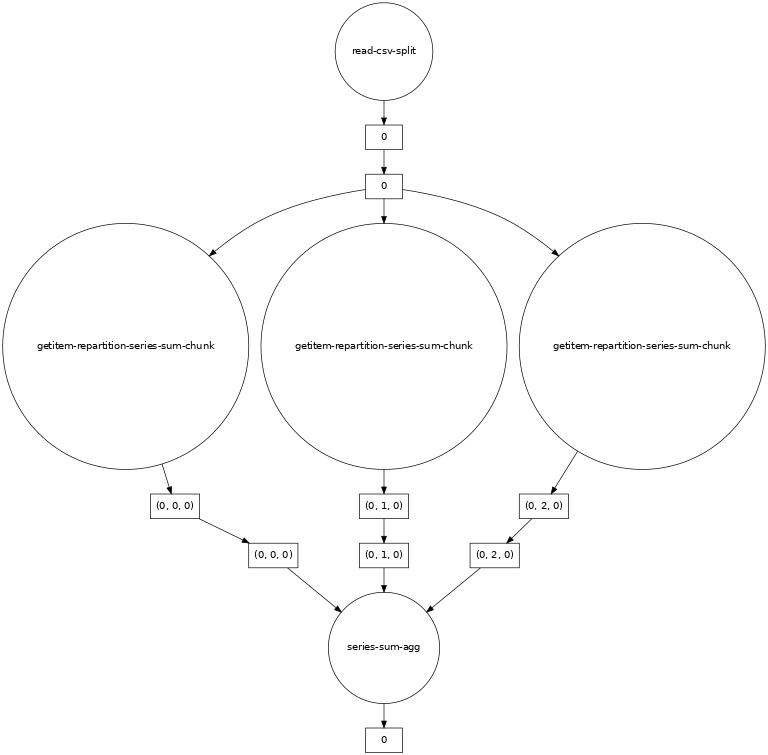

In [11]:
ddf_A = dask_cudf.read_csv("data/AQC00914594.csv").repartition(npartitions=3)
ddf_A["Dly_Squared"] = ddf_A["DlySum"]**2
ddf_A["Dly_Squared"].sum().visualize(filename='graph.jpeg', optimize_graph=True, size="8", rankdir="TB")

## Plotting Big Data

Now that we have a way to quickly read and manipulate our data, let's make an interactive graph. [Plotly](https://plotly.com/) is a popular library for graphing and data dashboards.

In order for Plotly to make a graph, data needs to be on the host, not the GPU.

<center><img src=images/GPU_Dash.png width=600px /></center>

If our dataset is small, it's not worth it to do the round trip between our host RAM and our GPU. However, if we have a large dataset (like we do with our precipitation dataset), sending our data to the GPU is a great way to speed up computation. Because of this, GPU integration is a great way to make interactive graphs where users can set query boundaries for the data.

Let's try plotting our precipitation data on a map. Since we have data for multiple days, let's start with just one day and work up from there.

In [12]:
# Pick a day. Try your birthday :)
precip_one_day = ddf[ddf['DATE']==pd.Timestamp(1986, 10, 10)]

# Calculate a result and send to host
precip_one_day = precip_one_day.compute().to_pandas()

Plotly has a number of [different ways to plot maps](https://plotly.com/python/scatter-plots-on-maps/). We're going to use the [Scattergeo Graph Object](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Scattergeo.html) because it's a good balance of flexibility and ease of use.

**TODO:** Select the appropriate columns to make a Scattergeo graph. Click the `...` for a solution.

In [ ]:
%%time
import plotly.graph_objects as go

fig = go.Figure([go.Scattergeo(
    lon=precip_one_day['LONGITUDE'],
    lat=precip_one_day['LATITUDE'],
    mode='markers',
    marker_color=precip_one_day['DlySum'],
    text=precip_one_day['STATION'])])

fig.show()

In [ ]:
%%time
import plotly.graph_objects as go

fig = go.Figure([go.Scattergeo(
    lon=precip_one_day['LONGITUDE'],
    lat=precip_one_day['LATITUDE'],
    mode='markers',
    marker_color=precip_one_day['DlySum'],
    text=precip_one_day['STATION'])])

fig.show()

## Adding Style

Not a bad start! In the next lab, we'll see how to scale this to multiple days by creating an interactive dashboard. Debugging a web service is a bit trickier than debugging things locally, so this would be a good time to add some style to our graph.

In addition to the [Scattergeo](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Scattergeo.html) and [marker](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.scattergeo.html#plotly.graph_objects.scattergeo.Marker) options we had before, there's also the [update_layout](https://plotly.com/python/reference/layout/) method which gives us even more options to add our personal flair. We have a layout started below. Feel free to modify to your liking. If you would like some inspiration, checkout out our choices in the `...` below.

In [ ]:
fig = go.Figure([go.Scattergeo(
    lon=precip_one_day['LONGITUDE'],
    lat=precip_one_day['LATITUDE'],
    mode='markers',
    marker = dict(
            reversescale = True,
            autocolorscale = False,
            colorscale = 'Blues',
            cmin = 0,
            color = precip_one_day['DlySum'],
            cmax = precip_one_day['DlySum'].max(),
            colorbar_title="Precipitation in Hundredths of an Inch"
        ),
    text=precip_one_day['STATION'])])

fig.update_layout(
        title = 'USA Precipitation',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            landcolor = "rgb(225, 225, 225)",
            subunitcolor = "rgb(200, 200, 200)",
        ),
    )

fig.show()

In [ ]:
precip_one_day = ddf[ddf["DATE"] == pd.Timestamp(1986, 10, 10)]
# Make hovertext more descriptive
precip_one_day["Inches"] = precip_one_day["DlySum"] / 100
precip_one_day["TEXT"] = (
    precip_one_day["STATION"] + ": " + precip_one_day["Inches"].astype(str) + " inches"
)
precip_one_day = precip_one_day.compute().to_pandas()

fig = go.Figure(
        go.Scattergeo(
            lon=precip_one_day["LONGITUDE"],
            lat=precip_one_day["LATITUDE"],
            mode="markers",
            marker=dict(
                size=4,
                reversescale=True,
                autocolorscale=False,
                colorscale="Blues",
                cmin=0,
                color=precip_one_day["Inches"],
                cmax=precip_one_day["Inches"].max(),
                colorbar_title="Precipitation in Inches",
            ),
            text=precip_one_day["TEXT"]
        )
)

bgcolor = "rgb(25, 26, 26)"
ftcolor = "rgb(200, 200, 200)"
landcolor = "rgb(52, 51, 50)"

fig.update_layout(
    title="USA Precipitation",
    font_color=ftcolor,
    paper_bgcolor=landcolor,
    geo=dict(
        scope="north america",
        bgcolor=bgcolor,
        landcolor=landcolor,
        showsubunits = True,
        subunitcolor="rgb(73, 73, 73)",
        lakecolor=bgcolor,
        lonaxis_range=[-165.0, -55.0],
        lataxis_range=[25.0, 45.0]
    )
)

fig.show()

Ready to show off your style to the world? In the next notebook, we'll turn it into an interactive dashboard.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>